In [151]:
%matplotlib inline 
import numpy as np                       
from matplotlib import pyplot as plt      
import time, sys                   

### Постановка и сеточные параметры

Рассмотрим задачу об эволюции ступеньки. Численное решается уравнение переноса с коэффициентом переноса $c$.

In [152]:
nx = 41  # количество узлов по пространству
dx = 2 / (nx-1) # шаг по пространству
nt = 25    # количество узлов по времени
dt = .025  # шаг по времени
T = dt*(nt-1)
c = 1      # скорость распространения возмущения (коэффициент переноса)
x_mesh = np.linspace(0, 2, nx) #сетка по пространству
r = c*dt/dx # число Куранта
print('r = ', r)
print('T = ', T)
print('dx-c*dt = ', dx-c*dt)

r =  0.5
T =  0.6000000000000001
dx-c*dt =  0.025


#### Начальные условия

Зададим $u(x, 0) = 2$ при $x \in [0.5, 1]$ и $u(x, 0) = 1$ иначе во всей расчетной области. Такая функция называется "ступенька". 

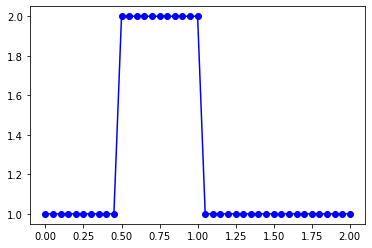

In [153]:
u_init = np.ones(nx)      
u_init[int(.5 / dx):int(1 / dx + 1)] = 2  
plt.plot(x_mesh, u_init, '-bo')

#### Точное решение

К моменту времени T ступенька просто сдвинется вправо

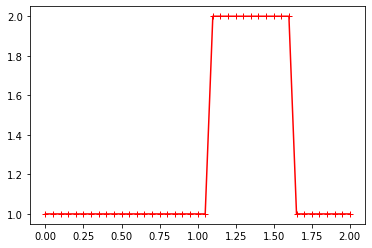

In [154]:
u_exact = np.ones(nx)      
u_exact[int((.5+c*T) / dx):int((1+c*T) / dx + 1)] = 2  
plt.plot(x_mesh, u_exact, '-r+')

### Численное решение

#### Часть 1. Явный левый уголок
Сначала примените схему Явный левый уголок (Upwind scheme). Провести расчеты для $nx = 41; 81; 121$. Построить графики решения

In [155]:
un = np.ones(nx) # инициализация вспомогательного массива для хранения
                 # данных с предыдущего шага
u = u_init.copy()
for n in range(1, nt):  # шагаем по времени
    un = u.copy() # заполняем данными с предыдущего шага
    for i in range(1, nx): # шагаем по пространству
        u[i] = un[i] - r*(un[i] - un[i-1])

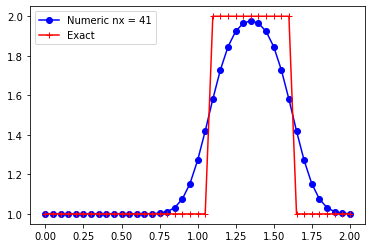

In [156]:
plt.plot(x_mesh, u, '-bo', label = 'Numeric nx = ' + str(nx))
plt.plot(x_mesh, u_exact, '-r+', label = 'Exact')
plt.legend()

In [165]:
def left_angle(nx): #я просто собрала все ваши кусочки кода
    dx = 2 / (nx-1)
    nt = 25
    dt = .025
    T = dt*(nt-1)
    c = 1
    r = c*dt/dx
    x_mesh = np.linspace(0, 2, nx)
    u_exact = np.ones(nx)      
    u_exact[int((.5+c*T) / dx):int((1+c*T) / dx + 1)] = 2  
    u_init = np.ones(nx)      
    u_init[int(.5 / dx):int(1 / dx + 1)] = 2
    un = np.ones(nx)
    u = u_init.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx):
            u[i] = un[i] - r*(un[i] - un[i-1])
    plt.plot(x_mesh, u, '-bo', label = 'Numeric nx = ' + str(nx))
    plt.plot(x_mesh, u_exact, '-r+', label = 'Exact')
    plt.legend()

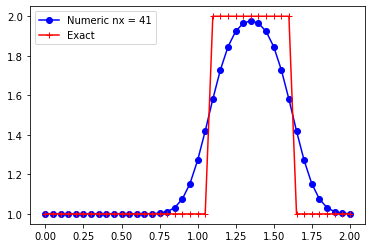

In [166]:
left_angle(41)

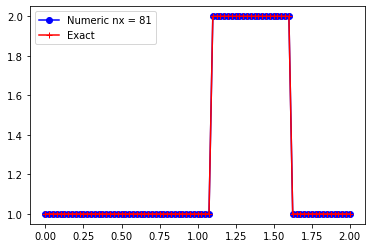

In [167]:
left_angle(81)

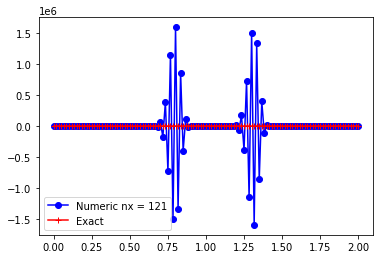

In [168]:
left_angle(121)

0. Какой у схемы порядок аппроксимации?\
    **Ответ:** У схемы первый порядок аппроксимации. Схема левый явный уголок для уравнения переноса:
    $$ \dfrac{u^{n+1}_m-u^n_m}{\tau}+c\dfrac{u^n_m - u^n_{m-1}}{h}=0$$
    Ниже я буду раскладывать в Тейлора и приму обозначение $u = u(x_m, t_n)$:
    $$ r^n_m = \dfrac{u +\tau u_t + \frac{\tau^2}{2!}u_{tt}+O(\tau^3)-u}{\tau}+c\dfrac{u - u +hu_x-\frac{h^2}{2!}u_{xx}+O(h^3)}{h} - u_t - cu_x =$$$$= u_t + cu_x + \frac{\tau}{2!}u_{tt}  -\frac{h}{2!}u_{xx} + O(\tau^2+h^2) - u_t - cu_x = O(\tau+h)$$
1. Удалось ли получить решение? Почему?\
    **Ответ:** Да, удалось для 41 и 81 узла. По теореме Лакса-Рябенького-Филиппова разностная схема аппроксимирует задачу и при $r\leq 1$ устойчива (для 41 и 81 узла $r\leq1$). Тогда решение разностной задачи сходится к решению дифференциальной.
2. Сколько граничных условий и где нужно поставить в этой задаче?\
   **Ответ:** У нас одно собственное число ($\lambda = 1$), причем положительное, поэтому нужно *одно левое* граничное условие 
3. Почему в задаче явно нигде не инициализируются граничные условия?\
    **Ответ:** Заметим, что левое граничное ( $u[0]=1$) условие переходит из массива в массив при копировании, и при итерациях по пространству мы не меняем нулевую ячейку, т.е. везде во времени сохраняется $u(0,t)=1$
4. Почему в цикле по пространству индексация с 1?\
    **Ответ:** Нулевая ячейка ( $u[0]$ ) сохраняет левое начальное условие (также мы объясняем и просто проход левым явным уголком, если рассматривать схему, которую я расписала в первом номере, то начиная с $m-1=0$ на основном уровне, мы получаем  значение в $m=1$ на следующем уровне, т.е. точке на один пункт $dx$ правее. 
5. Можно ли решить задачу схемой Явный правый уголок?\
    **Ответ:** Т.к. $c=1>0$, то явный правый уголок был бы неустойчивым, т.е. *нельзя*
6. Почему при решении на 41 узле решение размывается, а на 81 узле нет?\
    **Ответ:** Будем отсылаться к задаче $\text{XIV}.8.5$ (я честно ее разобрала). \
    Точное решение уравнения переноса будет иметь вид $u = e^{ik(x-ct)}$ (где $k$ - волновое число). Для разностной схемы ищем в виде $u^n_m = e^{\lambda t_n}e^{ikx_m} = e^{\lambda \tau n}e^{ikmh}$. После подстановки в левый явный уголок и сокращения на $e^{\lambda \tau n}e^{ikmh}$, получаем:
    $$ \dfrac{e^{\lambda\tau}-1}{\tau}+c\dfrac{1-e^{-ikh}}{h}=0 \hspace{0.5cm} \Rightarrow \hspace{0.5cm} \lambda = \dfrac{1}{\tau}\ln\left(1-\dfrac{c\tau}{h}+\dfrac{c\tau}{h}e^{-ikh}\right)$$
    $r = \dfrac{c\tau}{h}$ называется числом Куранта. Если $r=1$, то 
    $$ \lambda = \dfrac{1}{\tau}\ln\left(1-1+e^{-ikh}\right) = -\dfrac{ikh}{\tau} = -ik\dfrac{h}{\tau} = -ikc$$
    И тогда решение совпадает с точным: $u^n_m = e^{-ikc t_n}e^{ikx_m} = e^{ik(x_m-ct_n)}$. Именно это и происходит на 81 узле (число Куранта как раз получается равным $1$).\
    При $r\neq1$ разложим $\lambda$ по Тейлору (до второго порядка) в предположении $kh\ll 1$:
    $$\lambda \approx \dfrac{1}{\tau}\ln\left(1-\dfrac{c\tau}{h}+\dfrac{c\tau}{h} +\dfrac{c\tau}{h}(-ikh) -\dfrac{c\tau}{2h}k^2h^2\right) \approx \dfrac{1}{\tau}\left(\dfrac{c\tau}{h}(-ikh) -\dfrac{c\tau}{2h}k^2h^2 + \dfrac{c^2\tau^2}{2h^2}k^2h^2\right)= $$ $$= -ikc -\dfrac{ck^2h}{2} + \dfrac{c^2\tau k^2}{2} = -ick - \dfrac{ck^2}{2}(h-c\tau)$$
    Тогда $$ u^n_m = e^{ik(x_m-ct_n)}e^{-\frac{ck^2}{2}(h-c\tau)t_n}$$
    Где первая экспонента $e^{ik(x_m-ct_n)}$ совпадает с точным решением, а вторая экспонента при $c = 1>0$ и $h-c\tau = 0.025 >0$ (это я значение для 41 узла посчитала) затухает с ростом $t_n$, поэтому решение сглаживается
7. Объясните причину размытия решения.\
    **Ответ:** (объяснены в предыдущем пункте: из-за затухающей экспоненты)

Для ответа на шестой вопрос может быть полезна книга [1], c.71

1. Зализняк В.Е. Основы вычислительной физики. Часть 1. Введение в конечно-разностные методы

#### Часть 2. Схема МакКормака 

Теперь примените схему МакКормака (MacCormack method). Провести расчеты для $nx = 41; 81; 121$. Построить графики решения\
**Ответ:**\
Предиктор $$ \overline{u}^{n+1}_m = u^n_m -\dfrac{c\tau}{h}(u^n_{m+1}-u^n_m)$$
Корректор $$u^{n+1}_m = \dfrac{1}{2}\left(u^n_m + \overline{u}^{n+1}_m-\dfrac{c\tau}{h}(\overline{u}^{n+1}_m-\overline{u}^{n+1}_{m-1})\right) $$

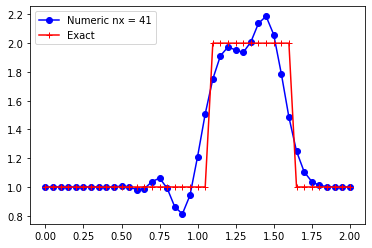

In [158]:
def MacCormack(nx):
    dx = 2 / (nx-1)
    nt = 25
    dt = .025
    T = dt*(nt-1)
    c = 1
    r = c*dt/dx
    x_mesh = np.linspace(0, 2, nx)
    u_exact = np.ones(nx)      
    u_exact[int((.5+c*T) / dx):int((1+c*T) / dx + 1)] = 2  
    u_init = np.ones(nx)      
    u_init[int(.5 / dx):int(1 / dx + 1)] = 2
    un = np.ones(nx) #для хранения с предыдущего шага
    u_pre = np.ones(nx) #для предиктора
    u = u_init.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(0, nx-1):#предиктор заполняется с 0,т.к. для m-го шага корректора нужен m-1 шаг предиктора
            u_pre[i] = un[i] - r * (un[i+1] - un[i])
        for i in range(1, nx): #заполняем корректор, уже с 1
            u[i] = (un[i]+u_pre[i]- r * (u_pre[i]-u_pre[i-1]))/2.0
    plt.plot(x_mesh, u, '-bo', label = 'Numeric nx = ' + str(nx))
    plt.plot(x_mesh, u_exact, '-r+', label = 'Exact')
    plt.legend()

MacCormack(41)

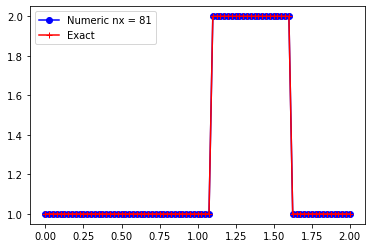

In [159]:
MacCormack(81)

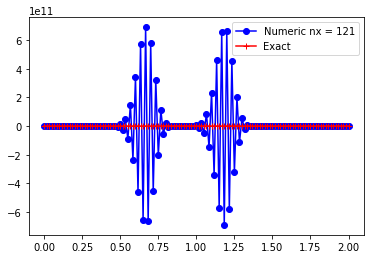

In [160]:
MacCormack(121)

0. Какой у схемы порядок аппроксимации?\
    **Ответ:** Порядок аппроксимации второй $O(\tau^2+h^2)$. Сначала подставим в формулу для корректора $\overline{u}^{n+1}_m$ из предиктора:
    $$u^{n+1}_m = \dfrac{1}{2}\left(u^n_m + u^n_m -\dfrac{c\tau}{h}(u^n_{m+1}-u^n_m)-\dfrac{c\tau}{h}(u^n_m -\dfrac{c\tau}{h}(u^n_{m+1}-u^n_m)-u^n_{m-1} +\dfrac{c\tau}{h}(u^n_{m}-u^n_{m-1}))\right) $$
    Перепишем в более читаемом виде:
    $$ \dfrac{u^{n+1}_m-u^n_m}{\tau}+c\dfrac{u^n_{m+1}-u^n_{m-1}}{2h}-c^2\tau\dfrac{u^n_{m+1}-2u^n_m+u^n_{m-1}}{2h^2}=0$$
    Теперь разложим по Тейлору до третьего порядка (обозначения аналогично предыдущей части $u(t_n, x_m) = u)$:
    $$ r^n_m = \dfrac{u + \tau u_t +\frac{\tau^2}{2}u_{tt} + \frac{\tau^3}{6}u_{ttt}-u}{\tau} + c\dfrac{u + hu_x +\frac{h^2}{2}u_{xx}+\frac{h^3}{6}u_{xxx}-u +hu_x - \frac{h^2}{2}u_{xx} + \frac{h^3}{6}u_{xxx}}{2h}$$
    $$-c^2\tau\dfrac{u + hu_x +\frac{h^2}{2}u_{xx}+\frac{h^3}{6}u_{xxx} - 2u +u - hu_x +\frac{h^2}{2}u_{xx}-\frac{h^3}{6}u_{xxx}}{2h^2} - u_t -cu_x = $$ $$=u_t +\frac{\tau}{2}u_{tt}+\frac{\tau^2}{6}u_{ttt} + cu_x +c\frac{h^2}{6}u_{xxx} -c^2\frac{\tau}{2}u_{xx}-u_t-cu_x  = \frac{\tau}{2}(u_{tt}-c^2u_{xx})+O(\tau^2+h^2) = O(\tau^2+h^2)$$
    Последний переход (обнуление скобки $u_{tt}-c^2u_{xx}$) происходит из связи вторых производных. Продифференцируем исходное уравнение перехоса сначала по $t$, а потом по $x$:
    $$ \begin{cases}u_{tt} + cu_{xt}=0 \\ u_{tx} +cu_{xx}=0 \end{cases} \Rightarrow \hspace{0.5cm} +  \ u_{tx}=u_{xt} \Rightarrow \hspace{0.5cm} u_{tt}-c^2u_{xx}=0$$
1. Удалось ли получить решение? Почему?\
    **Ответ:** Да, удалось для 41 и 81 узла. По теореме Лакса-Рябенького-Филиппова разностная схема аппроксимирует задачу и при $r\leq 1$ устойчива (для 41 и 81 узла $r\leq1$). Тогда решение разностной задачи сходится к решению дифференциальной.
2. Почему при решении на 41 узле решение осциллирует, а на 81 узле нет?\
    **Ответ:** Используя обозначение для числа Куранта $r = \dfrac{c\tau}{h}$ перепишем схему в виде:
    $$u^{n+1}_m-u^n_m + \dfrac{r}{2}(u^n_{m+1}-u^n_{m-1})-\dfrac{r^2}{2}(u^n_{m+1}-2u^n_m+u^n_{m-1}) =0$$
    Подставляем $u^n_m = e^{\lambda t_n}e^{ikx_m} = e^{\lambda \tau n}e^{ikmh}$ и сразу сокращаем на эту величину. Получаем: 
    $$ e^{\lambda\tau}-1+r\dfrac{e^{ikh}-e^{-ikh}}{2}-r^2\dfrac{e^{ikh}-2+e^{-ikh}}{2} =e^{\lambda\tau}-1+ir\sin{kh} -r^2(\cos{kh}-1)=0$$
    $$ \lambda = \dfrac{1}{\tau}\ln\left(1-ir\sin{kh} +r^2(\cos{kh}-1)\right)$$
    На 81 узле $r=1$, т.е.
    $$ \lambda = \dfrac{1}{\tau}\ln\left(1-i\sin{kh} +\cos{kh}-1\right) = \dfrac{1}{\tau}\ln\left(e^{-ikh}\right)=-ik\dfrac{h}{\tau} = -ikc$$
    Т.е. решение совпадает с точным $u^n_m = e^{ik(x_m-ct_n)}$ и никаких осцилляций нет.\
    Для остальных $r\neq 1$ будем раскладывать в ряд Тейлора (до третьего порядка):
    $$ \lambda \approx \dfrac{1}{\tau}\ln\left(1-irkh+ir\frac{k^3h^3}{6} +r^2\left(1-\frac{k^2h^2}{2}-1\right)\right)\approx -ir\dfrac{kh}{\tau}+ir\dfrac{k^3h^3}{3!\tau}-r^2\dfrac{k^2h^2}{2\tau}+r^2\dfrac{k^2h^2}{2\tau}-2ir^3r^2\dfrac{k^3h^3}{4\tau}=$$ $$=-ikc +ikc\dfrac{k^2h^2}{6} -ikcr^2\dfrac{k^2h^2}{2} = -ikc+ikcr^2\dfrac{k^2h^2}{6}(1-3r^2)$$
    Тогда
    $$ u^n_m = e^{ik(x_m-ct_n)}\exp\left\{ikcr^2\dfrac{k^2h^2}{6}(1-3r^2)\right\}$$
    Появился экспонента с мнимой степенью, т.е. осциллирующая компонента
3. Объясните причину осцилляций.\
    **Ответ:** объяснено в предыдущем пункте
4. Совпадает ли схема со схемой Лакса-Вендроффа для данной задачи (Lax–Wendroff method)?\
    **Ответ:** Да, для линейного волнового уравнения схема Мак-Кормака эквивалентна схеме Лакса-Вендроффа. Из задачи $\text{XIV}.8.5$ можем сравнить вид схемы Лакса-Вендроффа со схемой МакКормака и увидеть, что они совпадают

#### Часть 3. Монотонная схема высокого порядка

1. Можно ли построить линейную монотонную по Годунову схему с порядком выше первого? Почему?\
    **Ответ:** По *теореме Годунова* **не существует** монотонных линейных разностных схем для уравнения переноса с порядком аппроксимации выше первого.
2. Постройте монотонную схему порядка выше первого и примените к решению задачи из предыдущих частей.\
    **Ответ:** Пойдет же и схема Лакса-Вендроффа с аппроксимацией $O(\tau^2+h^2)$. Ее реализация - это по сути релизация предыдущей части, т.к. метод МакКорнака совпадает для простейшего уравнения переноса. Можно еще реализовать схему Бима-Уорминга тоже с $O(\tau^2+h^2)$ (в домашке она получалась методом неопределенных коэффициентов и доказывался порядок ее аппроксимации. Минусом данных схем являются области монотонности (т.е. они монотонны не на всей пространственно-временной сетке).\
    Схема Бима-Уорминга:
    $$\dfrac{u^{n+1}_m-u^n_m}{\tau}+c\dfrac{3u^n_{m+1}-4u^n_m +u^n_{m-1}}{2h}-c^2\tau\dfrac{u^n_{m+1}-2u^n_m+u^n_{m-1}}{2h^2}=0 $$
    $$ u^{n+1}_m=u^n_m-r\dfrac{3u^n_{m+1}-4u^n_m +u^n_{m-1}}{2}+r^2\dfrac{u^n_{m+1}-2u^n_m+u^n_{m-1}}{2}=0$$

In [161]:
#реализация Бима-Уорминга
def Beam_Warming(nx):
    dx = 2 / (nx-1)
    nt = 25
    dt = .025
    T = dt*(nt-1)
    c = 1
    r = c*dt/dx
    x_mesh = np.linspace(0, 2, nx)
    u_exact = np.ones(nx)      
    u_exact[int((.5+c*T) / dx):int((1+c*T) / dx + 1)] = 2  
    u_init = np.ones(nx)      
    u_init[int(.5 / dx):int(1 / dx + 1)] = 2
    un = np.ones(nx)
    u = u_init.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx-1):
            u[i] = un[i] - r*(3*un[i+1] -4*un[i-1]+un[i-1])*0.5 + r*r*(un[i+1]-2*un[i]+un[i-1])*0.5
    plt.plot(x_mesh, u, '-bo', label = 'Numeric nx = ' + str(nx))
    plt.plot(x_mesh, u_exact, '-r+', label = 'Exact')
    print("r = ", r)
    plt.legend()

r =  0.5


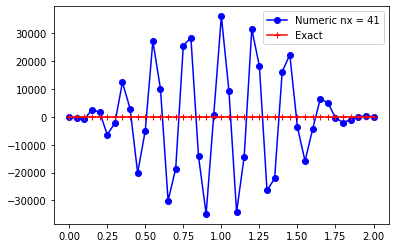

In [162]:
Beam_Warming(41)

r =  0.25


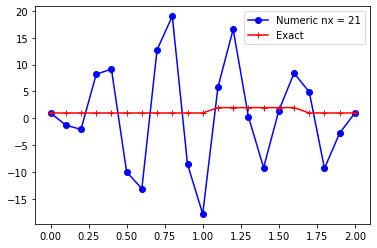

In [169]:
Beam_Warming(21)

r =  1.0


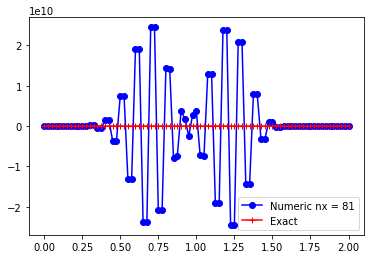

In [170]:
Beam_Warming(81)

Очень странное поведение, т.к. насколько я помню для Бима-Уорминга устойчивость при $r\leq 0.5$ должна наблюдаться. Ниже я изменила параметр $dt$, чтобы как можно сильнее уменьшить $r$. При этом $nt$ не трогаю, поэтому смещается он на расстояние гораздо меньшее

r =  0.005


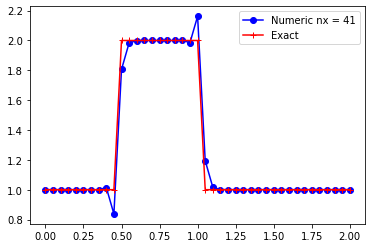

In [176]:
def Beam_Warming2(nx):
    dx = 2 / (nx-1)
    nt = 25
    dt = .00025
    T = dt*(nt-1)
    c = 1
    r = c*dt/dx
    x_mesh = np.linspace(0, 2, nx)
    u_exact = np.ones(nx)      
    u_exact[int((.5+c*T) / dx):int((1+c*T) / dx + 1)] = 2  
    u_init = np.ones(nx)      
    u_init[int(.5 / dx):int(1 / dx + 1)] = 2
    un = np.ones(nx)
    u = u_init.copy()
    for n in range(1, nt):
        un = u.copy()
        for i in range(1, nx-1):
            u[i] = un[i] - r*(3*un[i+1] -4*un[i-1]+un[i-1])*0.5 + r*r*(un[i+1]-2*un[i]+un[i-1])*0.5
    plt.plot(x_mesh, u, '-bo', label = 'Numeric nx = ' + str(nx))
    plt.plot(x_mesh, u_exact, '-r+', label = 'Exact')
    print("r = ", r)
    plt.legend()
Beam_Warming2(41)

r =  0.0025


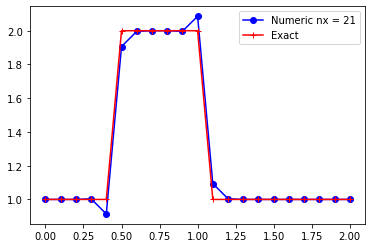

In [177]:
Beam_Warming2(21)

r =  0.01


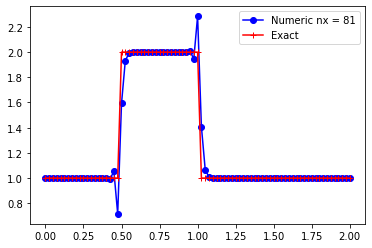

In [178]:
Beam_Warming2(81)